In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda



## Data Loading

In [74]:
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main")

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
%%bash
git clone https://github.com/asaparov/prontoqa.git
cd prontoqa
mkdir json
unzip generated_ood_data.zip -d json

In [4]:
import json

def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
data = load_json("prontoqa/json/1hop_ProofsOnly_random_noadj.json")

In [5]:
from random import randint

labels = ["is", "is not"]

def create_adversary(prompt, example):
    question = example['question']
    cot = example['chain_of_thought']
    adv_cot = cot.copy()
    if " are not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are not ", " are ")
    elif " is not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is not ", " is ")
    elif " are " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are ", " are not ")
    elif " is " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is ", " is not ")
    else:
        raise "is not/is haven't been found in string!"

    if cot[1] in question:
        adv_question = question.replace(cot[1], adv_cot[1])
    else:
        raise "CoT not found in question!"
        
    return adv_question + '\n'

def prepare_example(example, n_shots=5, with_cot=True):
    prompt = "Answer True or False to the following question. Answer as in the examples.\n\n"
    cot_prompt = "Think step-by-step.\n\n" if with_cot else ""
    
    for i in range(n_shots):
        prompt += example[f"in_context_example{i}"]['question'] + "\n"
        query = example[f"in_context_example{i}"]['query']
        label = "False" if "is not" in query else "True"
        
        if "is not" in query:
            name, adj = query.split(" is not ")
        else:
            name, adj = query.split(" is ")
        
        name = name.split("Prove: ")[-1]
        query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
        prompt += "Question: " + query + cot_prompt

        if with_cot:
            for j, step in enumerate(example[f"in_context_example{i}"]['chain_of_thought']):
                prompt += f"({j+1}) {step}\n"
        
        prompt += f"Answer: {label}\n\n"

    adversary = prompt + create_adversary(prompt, example['test_example'])
    prompt += example["test_example"]['question'] + "\n"
    query = example["test_example"]['query']
    label = "False" if "is not" in query else "True"
    cot = example["test_example"]['chain_of_thought']
    
    if "is not" in query:
        name, adj = query.split(" is not ")
    else:
        name, adj = query.split(" is ")

    name = name.split("Prove: ")[-1]
    query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
    prompt += "Question: " + query + cot_prompt
    adversary += "Question: " + query + cot_prompt
        
    return prompt, label, cot, adversary

In [6]:
prepare_example(list(data.values())[0], n_shots=3, with_cot=False)

('Answer True or False to the following question. Answer as in the examples.\n\nDumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.\nQuestion: Is Polly muffled?\nAnswer: True\n\nEvery lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuses are angry. Alex is a rompus. Alex is a vumpus.\nQuestion: Is Alex rainy?\nAnswer: Tr

In [7]:
prompts = [prepare_example(x, n_shots=7, with_cot=True) for x in data.values()]

In [8]:
print(prompts[0][0])
print(prompts[0][1])
print(prompts[0][2])

Answer True or False to the following question. Answer as in the examples.

Dumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.
Question: Is Polly muffled?
Think step-by-step.

(1) Polly is an impus.
(2) Every impus is muffled.
(3) Polly is muffled.
Answer: True

Every lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuse

### Model loading and evaluation

In [9]:
model_name = 'gemma-2b'

In [10]:
model = HookedTransformer.from_pretrained(model_name, torch_dtype=torch.float32, n_devices=2)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


In [13]:
import re

def extract_answer(text):
    pattern = r'Answer:\s*(.*)'
    match = re.search(pattern, text)
    
    if match:
        answer = match.group(1)
    else:
        answer = "NaN"

    return answer

def extract_cot(text):
    pattern = re.compile(r'\(\d+\) ([^\n]+)')
    matches = pattern.findall(text)

    return matches

def generate_until_stop(prompt, stop_tokens, max_tokens=64, verbose=False):
    if isinstance(stop_tokens[0], str):
        stop_tokens = [model.to_single_token(tok) for tok in stop_tokens]
        
    tokens = model.to_tokens(prompt)
    gen = True
    while gen:
        with torch.no_grad():
            new_tok = model(tokens).argmax(-1)[:, -1]
        
        if verbose: print(model.to_string(new_tok), end='')
        tokens = torch.cat([tokens, new_tok[None].to(tokens.device)], dim=-1)
        if new_tok.item() in stop_tokens or max_tokens == 0:
            gen = False
        max_tokens -= 1

    return model.to_string(tokens)[0]

In [323]:
#api_key = input()
#os.environ['ANYSCALE_API_KEY'] = api_key

In [324]:
#from openai import OpenAI

#llm = OpenAI(
#           base_url = "https://api.endpoints.anyscale.com/v1",
#           api_key=os.environ['ANYSCALE_API_KEY'],
#        )

#def api_generate(prompt, model, **kwargs):
#    response = llm.chat.completions.create(
#            model = model,
#            messages = [
#                {'role': 'user', 'content': prompt}
#            ],
#            **kwargs
#        )
#    return response.choices[0].message.content

In [14]:
# Testing
idx = 0
x_clean = prompts[idx][0]
x_corr = prompts[idx][3]

print(f"Target CoT: {' -> '.join(prompts[idx][2])} | {prompts[idx][1]}\n")

clean_out = generate_until_stop(x_clean, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]
print('\n\n')
corr_out = generate_until_stop(x_corr, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]

clean_pred = extract_answer(clean_out)
corr_pred = extract_answer(corr_out)

clean_cot = extract_cot(clean_out)
corr_cot = extract_cot(corr_out)

print(f"\nClean CoT: {' -> '.join(clean_cot)} | {clean_pred}")
print(f"\nCorrupted CoT: {' -> '.join(corr_cot)} | {corr_pred}")

Target CoT: Wren is a grimpus. -> Every grimpus is not cold. -> Wren is not cold. | False

(1) Wren is a grimpus.
(2) Every grimpus is not cold.
(3) Wren is not cold.
Answer: False


(1) Wren is a grimpus.
(2) Every grimpus is cold.
(3) Wren is cold.
Answer: True
Clean CoT: Wren is a grimpus. -> Every grimpus is not cold. -> Wren is not cold. | False

Corrupted CoT: Wren is a grimpus. -> Every grimpus is cold. -> Wren is cold. | True


In [74]:
results_df = {
    'prompt': [],
    'label': [],
    'prompt_corr': [],
    'cot_gold': [],
    'pred': [],
    'cot_pred': []
}

stop_tokens = [" True", " False"]

err_count = 0
for i in tqdm(range(100)):
    prompt, label, cot, adv = prompts[i]
    out = generate_until_stop(prompt, stop_tokens)[len(prompt):]
    #out = api_generate(prompt, model_name, max_tokens=128, temperature=0)

    pred = extract_answer(out)
    cot_pred = extract_cot(out)
    
    if pred == "NaN": err_count += 1
    results_df['prompt'].append(prompt)
    results_df['label'].append(label)
    results_df['prompt_corr'].append(adv)
    results_df['cot_gold'].append(cot)
    results_df['pred'].append(pred)
    results_df['cot_pred'].append(cot_pred)

results_df = pd.DataFrame(results_df)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [ ]:
def check_cot(x):
    try:
        check = all([x == y for x, y in zip(x['cot_gold'], x['cot_pred'])])
    except: check = False

    return check
        
results_df['correct_pred'] = results_df['label'] == results_df['pred']
results_df['correct_cot'] = results_df.apply(check_cot, axis=1)

In [78]:
print(f"Correct label predictions: {results_df['correct_pred'].mean()}")
print(f"Correct CoT predictions: {results_df['correct_cot'].mean()}")
print(f"Label CoT correlation: {(results_df['correct_pred'] * results_df['correct_cot']).mean() / min(results_df['correct_pred'].mean(), results_df['correct_cot'].mean())}")

Correct label predictions: 0.63
Correct CoT predictions: 1.0
Label CoT correlation: 1.0


In [16]:
correct_preds = pd.read_csv('correct_pred.csv')
#correct_preds = results_df[results_df['correct_pred'] & results_df['correct_cot']]
#correct_preds.to_csv('correct_pred.csv', index=False)
correct_preds.head()

,prompt,label,prompt_corr,cot_gold,pred,cot_pred,correct_pred,correct_cot
0,Answer True or False to the following question...,False,Answer True or False to the following question...,"['Wren is a grimpus.', 'Every grimpus is not c...",False,"['Wren is a grimpus.', 'Every grimpus is not c...",True,True
1,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Rex is a jompus.', 'Each jompus is dull.', '...",True,"['Rex is a jompus.', 'Each jompus is dull.', '...",True,True
2,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Fae is a brimpus.', 'Each brimpus is transpa...",True,"['Fae is a brimpus.', 'Each brimpus is transpa...",True,True
3,Answer True or False to the following question...,False,Answer True or False to the following question...,"['Stella is a brimpus.', 'Brimpuses are not ra...",False,"['Stella is a brimpus.', 'Brimpuses are not ra...",True,True
4,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Wren is a tumpus.', 'Tumpuses are blue.', 'W...",True,"['Wren is a tumpus.', 'Tumpuses are blue.', 'W...",True,True


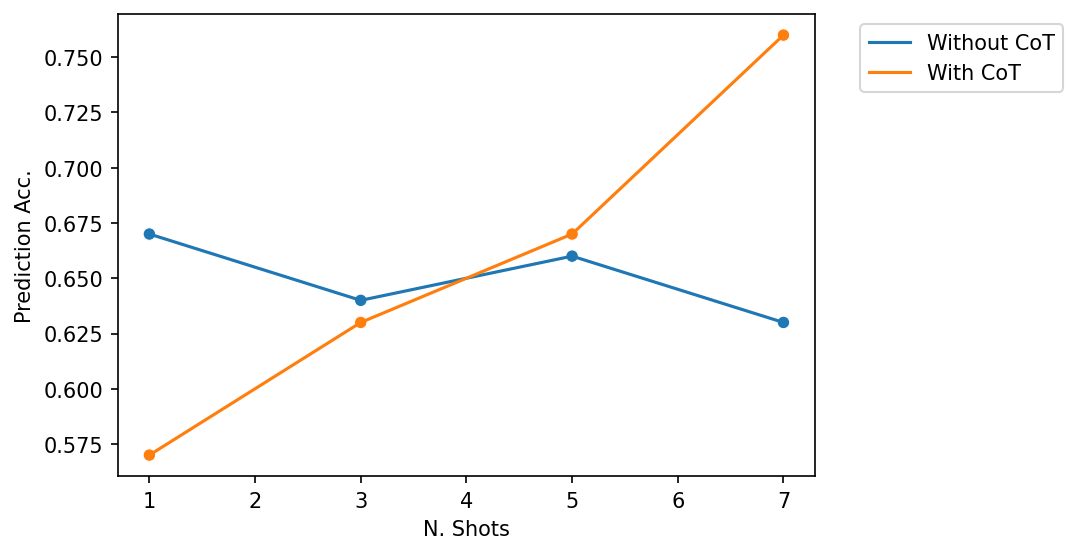

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=150)

shots_results = pd.DataFrame({
    'N. Shots': [1, 3, 5, 7, 1, 3, 5, 7],
    'Prediction Acc.': [0.57, 0.63, 0.67, 0.76, 0.67, 0.64, 0.66, 0.63],
    'CoT Acc.': [0.14, 0.21, 0.22, 0.27, 0, 0, 0, 0],
    'Agreement': [0.643, 0.810, 0.955, 0.963, 0, 0, 0, 0],
    'With CoT': [True, True, True, True, False, False, False, False] 
})

sns.lineplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')
sns.scatterplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Without CoT', 'With CoT'], bbox_to_anchor=(1.05, 1), loc='upper left')

(0.0, 1.0)

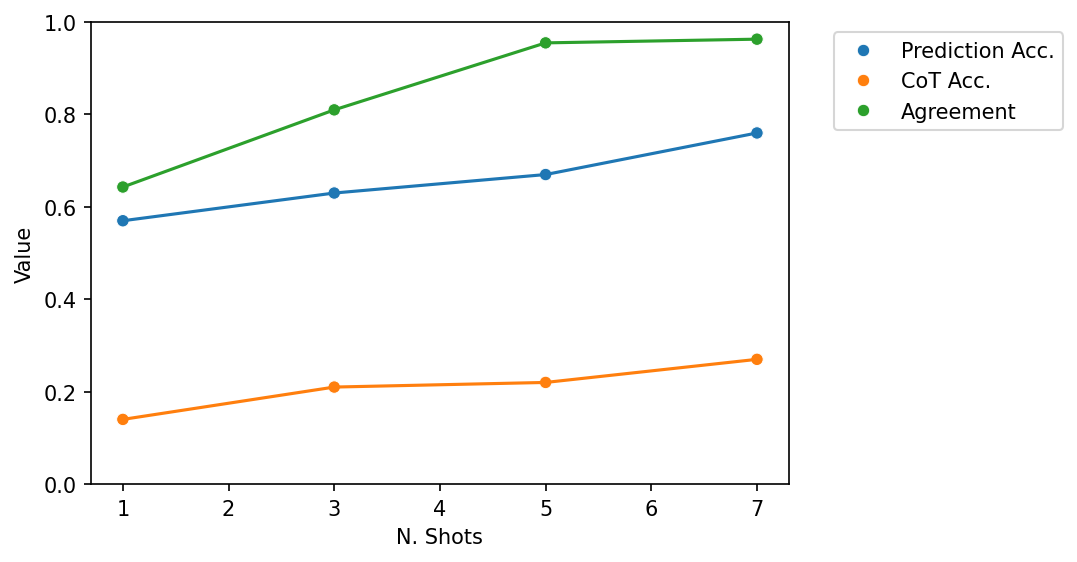

In [90]:
fig = plt.figure(figsize=(6, 4), dpi=150)
plot_df = shots_results.iloc[:4].drop('With CoT', axis=1).melt(id_vars='N. Shots', var_name='Score', value_name='Value')

sns.scatterplot(plot_df, x='N. Shots', y='Value', hue='Score')
sns.lineplot(plot_df, x='N. Shots', y='Value', hue='Score')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

## Attribution analysis 

In [32]:
def logits_diff(logits, a_clean, a_corr=None):
    if isinstance(a_clean, str):
        a_clean = model.to_single_token(a_clean)
    if a_corr:
        if isinstance(a_corr, str):
            a_corr = model.to_single_token(a_corr)
        
        return logits[0, -1, a_clean] - logits[0, -1, a_corr]
    else:
        return logits[0, -1, a_clean]

def get_cache_fw(tokens, component):
    if component == 'all':
        filter = lambda name: "_input" not in name
    else:
        filter = lambda name: component in name

    model.reset_hooks()

    cache = {}
    def fw_cache_hook(act, hook):
        cache[hook.name] = act.detach()

    model.add_hook(filter, fw_cache_hook, "fwd")
    
    logits = model(tokens)
    model.reset_hooks()
    return logits, ActivationCache(cache, model)

def get_cache_fw_and_bw(tokens, a_clean, a_corr, corr_logits, component='all'):
    if component == 'all':
        filter = lambda name: "_input" not in name
    else:
        filter = lambda name: component in name
        
    model.reset_hooks()
    
    cache = {}
    def fw_cache_hook(act, hook):
        cache[hook.name] = act.detach()

    model.add_hook(filter, fw_cache_hook, "fwd")
    
    grad_cache = {}
    def bw_cache_hook(act, hook):
        grad_cache[hook.name] = act.detach()
    
    model.add_hook(filter, bw_cache_hook, "bwd")

    clean_logits = model(tokens)
    value = logits_diff(clean_logits, a_clean, a_corr) - logits_diff(corr_logits, a_clean, a_corr)
    value.backward()
    
    model.reset_hooks()
    return (
        value.item(),
        ActivationCache(cache, model),
        ActivationCache(grad_cache, model),
    )

In [33]:
idx = 0
x_clean = correct_preds['prompt'].iloc[idx]
a_clean = correct_preds['label'].iloc[idx]
x_corr = correct_preds['prompt_corr'].iloc[idx]
cot_gold = correct_preds['cot_gold'].iloc[idx]

In [20]:
print('CLEAN')
print(x_clean.split('\n\n')[-2])
print('\nCORRUPTED')
print(x_corr.split('\n\n')[-2])

CLEAN
Gorpuses are sterpuses. Gorpuses are grimpuses. Every dumpus is a jompus. Every grimpus is a shumpus. Gorpuses are not small. Sterpuses are liquid. Every shumpus is not muffled. Dumpuses are bright. Each grimpus is a brimpus. Every grimpus is not cold. Wren is a dumpus. Wren is a grimpus.
Question: Is Wren cold?
Think step-by-step.

CORRUPTED
Gorpuses are sterpuses. Gorpuses are grimpuses. Every dumpus is a jompus. Every grimpus is a shumpus. Gorpuses are not small. Sterpuses are liquid. Every shumpus is not muffled. Dumpuses are bright. Each grimpus is a brimpus. Every grimpus is cold. Wren is a dumpus. Wren is a grimpus.
Question: Is Wren cold?
Think step-by-step.


In [36]:
stop_tokens = [' True', ' False']

print("Generating...")
clean_out = generate_until_stop(x_clean, stop_tokens)
corr_out = generate_until_stop(x_corr, stop_tokens)

Generating...


In [24]:
print("CLEAN RUN", clean_out.split("step-by-step.")[-1], sep='')
print("\nCORRUPTED RUN", corr_out.split("step-by-step.")[-1], sep='')

CLEAN RUN

(1) Wren is a grimpus.
(2) Every grimpus is not cold.
(3) Wren is not cold.
Answer: False

CORRUPTED RUN

(1) Wren is a grimpus.
(2) Every grimpus is cold.
(3) Wren is cold.
Answer: True


In [24]:
from functools import partial

# Tokenization and caching
idx = 1
a_corr = ' False' if a_clean else ' True'
a_clean = ' ' + str(a_clean)

clean_out = generate_until_stop(x_clean, stop_tokens=[':'])
corr_out = generate_until_stop(x_corr, stop_tokens=[':'])

clean_tokens = model.to_tokens(clean_out, prepend_bos=False)
with torch.no_grad():
    clean_logits = model(clean_tokens)

clean_logit_diff = logits_diff(clean_logits, a_clean, a_corr)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corr_tokens = model.to_tokens(corr_out, prepend_bos=False)
with torch.no_grad():
    corr_logits = model(corr_tokens)

corr_logit_diff = logits_diff(corr_logits, a_clean, a_corr)
print(f"Corrupted logit difference: {corr_logit_diff.item():.3f}")

Clean logit difference: 0.645
Corrupted logit difference: -0.378


In [53]:
list(enumerate(zip(
    model.to_str_tokens(clean_out),
    model.to_str_tokens(corr_out),
)))[839:]

[(839, ('.', '.')),
 (840, (' Every', ' Every')),
 (841, (' gri', ' gri')),
 (842, ('mp', 'mp')),
 (843, ('us', 'us')),
 (844, (' is', ' is')),
 (845, (' not', ' cold')),
 (846, (' cold', '.')),
 (847, ('.', ' Wren')),
 (848, (' Wren', ' is')),
 (849, (' is', ' a')),
 (850, (' a', ' dump')),
 (851, (' dump', 'us')),
 (852, ('us', '.')),
 (853, ('.', ' Wren')),
 (854, (' Wren', ' is')),
 (855, (' is', ' a')),
 (856, (' a', ' gri')),
 (857, (' gri', 'mp')),
 (858, ('mp', 'us')),
 (859, ('us', '.')),
 (860, ('.', '\n')),
 (861, ('\n', 'Question')),
 (862, ('Question', ':')),
 (863, (':', ' Is')),
 (864, (' Is', ' Wren')),
 (865, (' Wren', ' cold')),
 (866, (' cold', '?')),
 (867, ('?', '\n')),
 (868, ('\n', 'Think')),
 (869, ('Think', ' step')),
 (870, (' step', '-')),
 (871, ('-', 'by')),
 (872, ('by', '-')),
 (873, ('-', 'step')),
 (874, ('step', '.')),
 (875, ('.', '\n\n')),
 (876, ('\n\n', '(')),
 (877, ('(', '1')),
 (878, ('1', ')')),
 (879, (')', ' Wren')),
 (880, (' Wren', ' is')),

In [66]:
pad_pod = [845, 896, 905]

In [95]:
#def get_ig_patching(clean_tokens, corr_tokens, a_clean, a_corr, component)

In [38]:
component = 'all'

with torch.no_grad():
    corr_logits, corr_cache = get_cache_fw(corr_tokens, component)
    
logits_diff_, clean_cache, clean_grad_cache = get_cache_fw_and_bw(clean_tokens, a_clean, a_corr, corr_logits, component=component)

/tmp/ipykernel_1392/693813141.py:8: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [47]:
clean_grad_cache = ActivationCache({k: v.to('cuda:0') for k, v in clean_grad_cache.items()}, model)
clean_cache = ActivationCache({k: v.to('cuda:0') for k, v in clean_cache.items()}, model)
corr_cache = ActivationCache({k: v.to('cuda:1') for k, v in corr_cache.items()}, model)

In [107]:
#clean_act = clean_cache.stack_head_results(-1).to('cuda:0')
#corr_act = corr_cache.stack_head_results(-1).to('cuda:0')
#clean_grad_act = clean_grad_cache.stack_head_results(-1).to('cuda:0')

corr_act = corr_cache.accumulated_resid(-1, incl_mid=True, return_labels=False).to('cuda:0')
clean_act = clean_cache.accumulated_resid(-1, incl_mid=True, return_labels=False).to('cuda:0')
clean_grad_act = clean_grad_cache.accumulated_resid(-1, incl_mid=True, return_labels=False).to('cuda:0')

# padding
for pos in reversed(pad_pod):
    corr_act = torch.cat([
        corr_act[:, :, :pos],
        torch.zeros_like(corr_act[:, :, 0, None]),
        corr_act[:, :, pos:]
    ], dim=2)

In [108]:
clean_act.shape, corr_act.shape

(torch.Size([37, 1, 910, 2048]), torch.Size([37, 1, 910, 2048]))

In [109]:
import einops
from tqdm import tqdm

patch = einops.reduce(
        clean_grad_act * (clean_act - corr_act),
        "component batch pos d_model -> component pos",
        "sum",
    )

In [110]:
patch.shape

torch.Size([37, 910])

In [104]:
print(model.to_str_tokens("Wren is not a gimpus."))
print(model.to_str_tokens("Wren is _ a gimpus."))

['<bos>', 'W', 'ren', ' is', ' not', ' a', ' g', 'imp', 'us', '.']
['<bos>', 'W', 'ren', ' is', ' _', ' a', ' g', 'imp', 'us', '.']


In [113]:
ys = []
for l in range(model.cfg.n_layers):
    ys.append(f"L{l} - pre")
    ys.append(f"L{l} - mid")

ys.append("Out")

In [116]:
import plotly.express as px

str_tokens = model.to_str_tokens(clean_out, prepend_bos=False)
n_last_tokens = 128

#ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(str_tokens[-n_last_tokens:])]

fig = px.imshow(
    patch[:, -n_last_tokens:].cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-.5, zmax=.5, aspect='auto'
)

fig.write_html("fig.html")

In [91]:
import plotly.express as px
import numpy as np

layer_id = 9
head_id = 5

data = clean_cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()
labels = [f"{tok} ({i})" for i, tok in enumerate(model.to_str_tokens(clean_out)[:-1])]

# Create the plot using Plotly Express
fig = px.imshow(
    data,
    labels=dict(x="Keys", y="Queries", color="Attention Score"),
    x=labels,
    y=labels,
    title=f'Attention patter at head {head_id} of layer {layer_id}',
    color_continuous_scale="Blues"
)

# Adjust the layout for better readability
fig.update_xaxes(tickangle=35)
fig.update_layout(coloraxis_colorbar=dict(title="Score"))

# Show the plot
fig.write_html("attn_pattern.html")

In [92]:
len(labels)

910

In [93]:
data.shape

torch.Size([910, 910])